<a href="https://colab.research.google.com/github/PolMix/nems_ai/blob/main/Neural%20ML/Neural_models_visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lib import

In [ ]:
import pandas as pd
import numpy as np
import scipy.stats as sps
import seaborn as sns
from copy import deepcopy

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Модели
import torch
import torch.nn as nn

!pip install torchview
from torchview import draw_graph
import graphviz
graphviz.set_jupyter_format('png')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


'svg'

Фиксация сида:

In [ ]:
import random

def set_random_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

set_random_seed(42)

Перенос модели на GPU:

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Модель Fully Connected + Batch Norm

### Построение модели

In [ ]:
num_pars_x = 8
num_pars_y = 20

class FCNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(in_features=num_pars_x, out_features=1000, bias=False),
            nn.BatchNorm1d(num_features=1000),
            nn.ReLU(),
            nn.Linear(in_features=1000, out_features=200, bias=False),
            nn.BatchNorm1d(num_features=200),
            nn.ReLU(),
            nn.Linear(in_features=200, out_features=num_pars_y, bias=True),
        )

    def forward(self, x):
        out = self.network(x)
        return out

    def init(self):
        relu_gain = torch.nn.init.calculate_gain('relu')
        for child in self.children():
            if isinstance(child, nn.Linear):
                if self.init_form == "normal":
                    torch.nn.init.kaiming_normal_(child.weight)

                    if child.bias is not None:
                        torch.nn.init.zeros_(child.bias)
                elif self.init_form == "uniform":
                    torch.nn.init.kaiming_uniform_(child.weight)

                    if child.bias is not None:
                        torch.nn.init.zeros_(child.bias)
                else:
                    raise NotImplementedError()

### Визуализация структуры модели

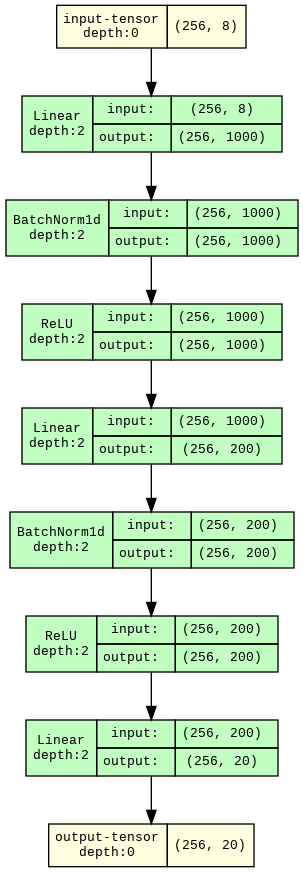

In [ ]:
model_mlp_graph = FCNetwork()

model_graph = draw_graph(model_mlp_graph, input_size=(256,8))
model_graph.visual_graph

# Модель Branched Fully Connected

### Построение модели

In [ ]:
class BranchedFCNetwork(nn.Module):
    def __init__(self, neck_features):
        super().__init__()
        self.network_general = nn.Sequential(
            nn.Linear(in_features=num_pars_x, out_features=300, bias=False),
            nn.BatchNorm1d(num_features=300),
            nn.ReLU(),
            nn.Linear(in_features=300, out_features=int(neck_features / 2), bias=False),
            nn.BatchNorm1d(num_features=int(neck_features / 2)),
            nn.ReLU(),
            nn.Linear(in_features=int(neck_features / 2), out_features=neck_features, bias=True),
            nn.ReLU()
        )

        # Короткая ветвь
        self.network_short = nn.Linear(in_features=neck_features, out_features=num_pars_y, bias=True)

        # Хранилище длинных ветвей
        self.network_branches = nn.ModuleList()

        # Длинные ветви
        for branch_index in range(0, 1):
            self.network_branches.append(BranchBlock(in_features=neck_features))



    def forward(self, x):
        batch_size_x = x.shape[0]

        # Проходим по общим слоям
        x = self.network_general(x)

        # Прохожим по короткой ветви
        out_1 = self.network_short(x)

        # Проходим по длинным ветвям
        for branch_index in range(0, 1):
            out_2 = self.network_branches[branch_index](x)

        return out_1, out_2

    # Инициализация весов
    def init(self):
        relu_gain = torch.nn.init.calculate_gain('relu')
        for child in self.children():
            if isinstance(child, nn.Linear):
                if self.init_form == "normal":
                    torch.nn.init.kaiming_normal_(child.weight)

                    if child.bias is not None:
                        torch.nn.init.zeros_(child.bias)
                elif self.init_form == "uniform":
                    torch.nn.init.kaiming_uniform_(child.weight)

                    if child.bias is not None:
                        torch.nn.init.zeros_(child.bias)
                else:
                    raise NotImplementedError()


# Блок длинной ветви для 1, 2 и 3 мод (НЕ ИСПОЛЬЗУЕТСЯ)
class BranchBlock(nn.Module):
    def __init__(self, in_features):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(in_features=in_features, out_features=500, bias=False),
            nn.BatchNorm1d(num_features=500),
            nn.ReLU(),
            nn.Linear(in_features=500, out_features=1, bias=False)
        )

    def forward(self, x):
        out = self.network(x)
        return out

### Визуализация структуры модели

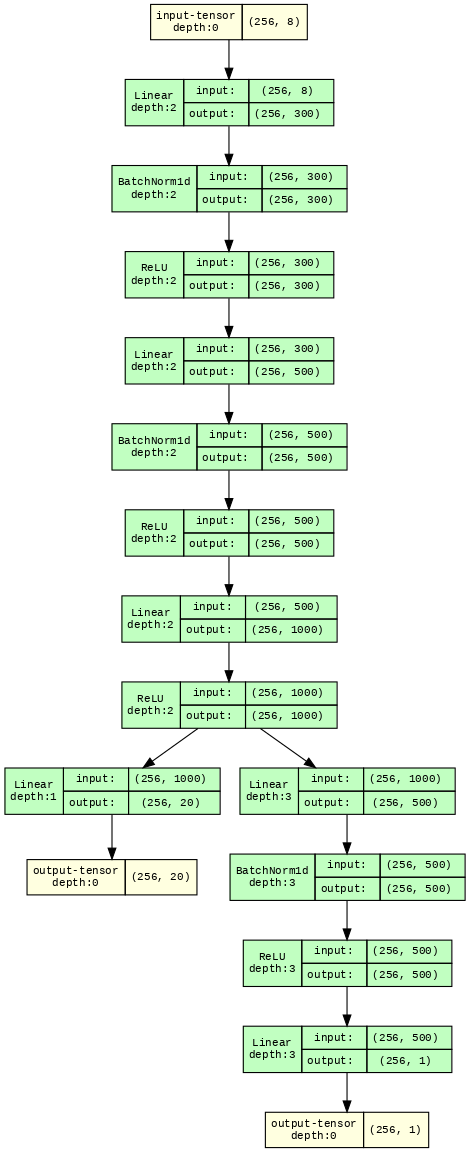

In [ ]:
model_branched_mlp_graph = BranchedFCNetwork(neck_features=1000)

model_graph = draw_graph(model_branched_mlp_graph, input_size=(256,8))
model_graph.visual_graph